In [1]:
# animation function. This is called sequentially
%matplotlib widget
%load_ext jupyter_spaces
# %matplotlib ipympl
import ipywidgets as widgets 
from ipywidgets import interact, interact_manual, GridspecLayout
from ipycanvas import RoughCanvas, Canvas, hold_canvas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datasets

# from IPython.display import Image, display


# Overview

In this notebook, you will be introduced to neural networks. Unlike previous notebooks, we will avoid any code details and focus on the core mechanisms that enable neural networks to fill gaps which normal algorithms have not been able to. This notebook will be centered on an example application (weed identification), but will also go beyond this example to give you a taste of some of the choices required when applying neural networks to a problem. After we go through the mechanisms of how to apply a neural network to your problem and building a neural network for our application there is an extra section delving into even more details on how we trained many of the networks in this notebook.

# Classifying weeds

Imagine we have an app which provides information about weeds in a user's local area. We have been geting requests from many users to build a feature that can take an image taken by their smartphones and recommend whether the plant is a weed (and thus needs to be pruned) or not. After several months of using simpler methods, the engineering team has decided we need to use a neural network to make this prediction. This is because the complexity of the input images are difficult to transform in a general way. For example here are two images produced from our users requesting this feature:

![alt text](dataset/raw_images/20160928-140337-0.jpg "Title") ![alt text](dataset/raw_images/20180125-092934-1.jpg "Title")

Notice how different these images look:
- The plants are in different locations in the image.
- The background is completely different colors.
- The plants are very different, and can't be identified easily if you aren't an expert.

We want our neural network to produce a prediction of whether the image contains a weed or not. After some search, we found a similar use case online with a corresponding dataset! This is the [DeepWeeds](https://github.com/AlexOlsen/DeepWeeds) dataset. While in the future we will want to collect our own data that is more representative of our userbase, we should test the viability of such a feature using this dataset.

# Neural Networks - Introduction/overview

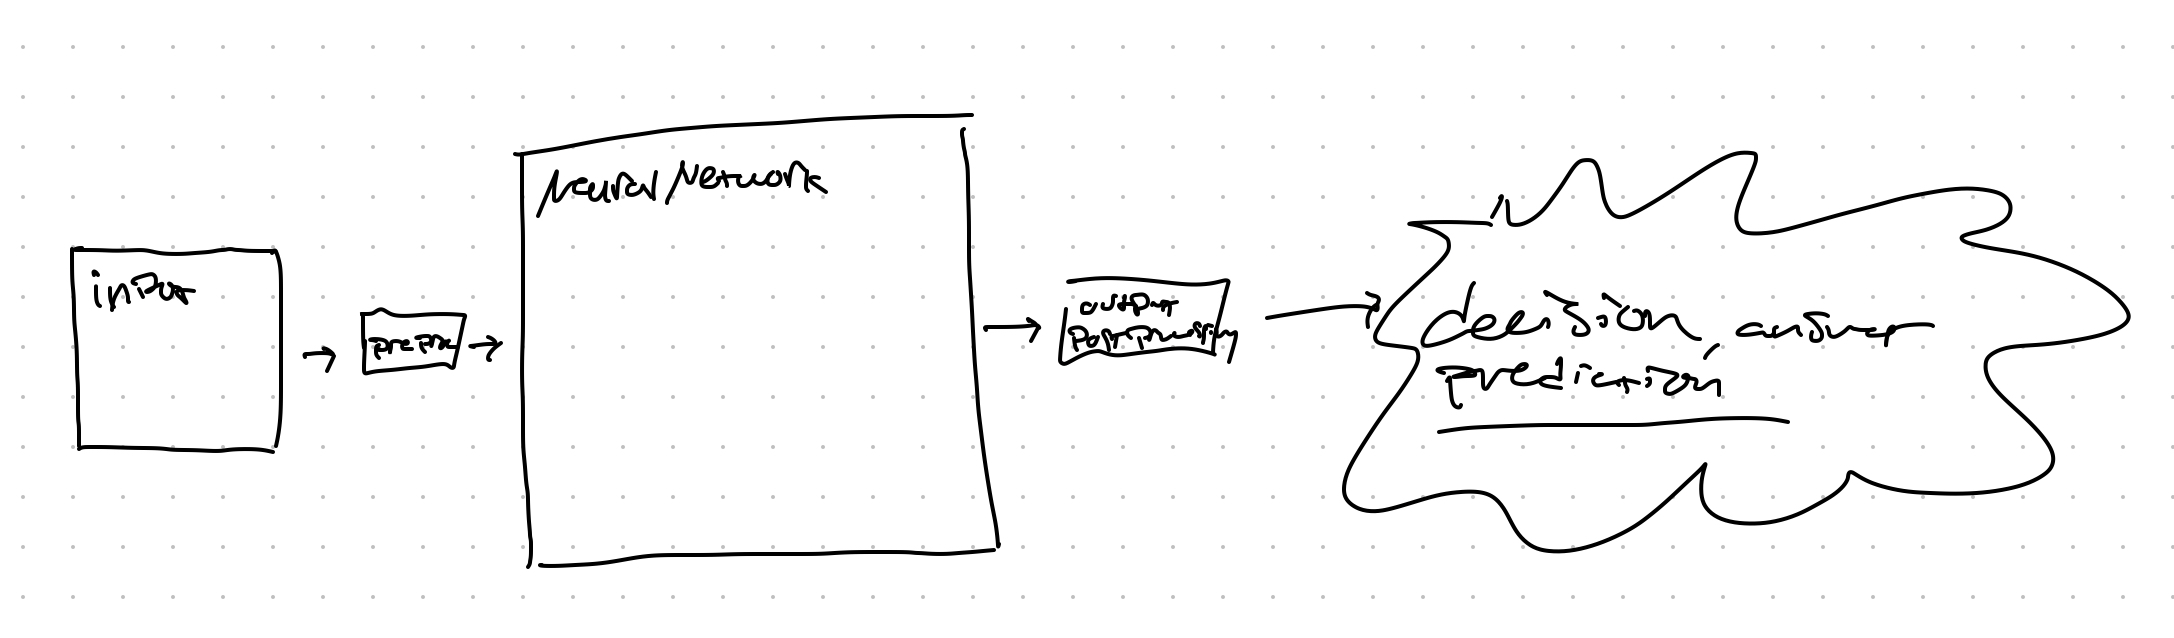

Above, you will see an image detailing the flow of data through a neural network. As with all the decision making algorithms you have been exposed to thus far, a neural network begins with the **input data**. After pre-processing the **input data** it is passed to the **neural network**, which is comprised of a number of **layers**. Each **layer** is a collection of **neurons**. A **neuron** takes the **output** of the previous **layer** (or the **input data** if it is the first layer) and transforms the data through an operation that is determined in the **training process**. The **neural network** outputs a set of numbers based on a number of factors. The **output** of the neural network must then be interpreted and processed to be used for a final decision. 

Don't be worried if you don't understand the above paragraph, or how data flows through the neural network right now. In the remainder of the notebook we will introduce the many facets of neural networks in more detail. Of course neural networks are more complex than we will cover here, but the goal is to give you a good base to begin to think critically about neural networks. In the next several sections, we will go through each part in more detail giving you the opportunity to gain intuition through interaction. You should keep our final use-case in mind! How would you use a neural network to determine if a plant is a weed? How would you pre-process the data to be useful for the neural network? Once you get to the final section you will have all the tools you need to think critically about these networks.


# Working through the design choices of a neural network

There are several levels of abstractions in building a neural network. In the next several sections, we go through each of the parts of the flow of a neural network found in the above description. These parts are as follows:
- **Output**: This section will delve into what a neural network can output, and how we might make decisions based on this data.
- **Input**: This section works to dig into some of the processing steps we need in-order to make data appropriate to input into a neural network.
- **Neurons and Layers**: This section deals with neurons and layers (the fundamental building blocks of all neural networks).

## Output

Below we have two examples. The first is a classification example using handwritten digits from the value of 0 to 9. This is a canonical dataset used in training neural networks. The second example is a regression example where we are focused on adding two numbers together. The data used for the regression example are positive values in the range 0 to 10. In both examples notice how the output changes with changes to the input. In the regression example, try numbers outside of the range we used for training (for example negative numbers or really large numbers).

### Classification Example

This example uses a neural network to classify hand-drawn digits in the range 0 to 9. Below you can investigate different digits using the button `Random Mnist Digit`, investigate a 0 digit using the button `Mnist Digit`, and you can draw on the digit canvas to see how it effects the networks output! The output of the network represents the neural networks belief of the likelihood it is seeing a digit. These numbers will update as the digit canvas changes.

In [2]:
%%space output_example
import train_mnist_network
predict, params = train_mnist_network.train_network(16)

canvas_dim = 140
canvas = Canvas(width=canvas_dim, height=canvas_dim, sync_image_data=True)
def get_image_data():
    try:
        digit_image = canvas.get_image_data()
        digit_image = digit_image[::5, ::5, 0]
        digit_image = digit_image / np.float32(255.)
        return digit_image
    except:
        return np.zeros((28,28), np.float32)

digit_canvas = Canvas(width=28, height=28)

out_canvas_height = 400
out_canvas_width = 600
output_canvas = RoughCanvas(width=out_canvas_width, height=out_canvas_height)


def reset_canvas(btn, cnvs=canvas, color="black"):
    cnvs.fill_style=color
    if isinstance(cnvs, RoughCanvas):
        rfs = cnvs.rough_fill_style
        cnvs.rough_fill_style = "solid"
        cnvs.fill_rect(0,0,cnvs.width,cnvs.height)
        cnvs.rough_fill_style = rfs
    else:
        cnvs.fill_rect(0,0,cnvs.width,cnvs.height)
reset_canvas(None)
reset_canvas(None, cnvs=output_canvas, color="white")
mnist_data = datasets.mnist_raw()[0]
                       
mouse_down = [False]

brightness_slider = widgets.IntSlider(min=0, max=255, value=0, layout=widgets.Layout(width="180px"))
size_slider = widgets.IntSlider(min=5, max=20, step=5, layout=widgets.Layout(width="180px"))
def rgb_to_hex(v):
    return '#{:02x}{:02x}{:02x}'.format(v, v, v)
reset_button = widgets.Button(description="Reset")
def reset_button_func(btn):
    reset_canvas(None)
    draw_output_canvas_from_input(np.zeros((28, 28), np.float32))
reset_button.on_click(reset_button_func)

zero_digit_button = widgets.Button(description="Mnist Digit")
def draw_zero_digit(btn):
    reset_canvas(None)
    image_data = np.repeat(mnist_data[1][:,:,np.newaxis], 3, 2)
    digit_canvas.put_image_data(image_data, 0, 0)
    canvas.draw_image(digit_canvas, 0, 0, canvas_dim, canvas_dim)
    draw_output_canvas_from_input(mnist_data[1] / np.float32(255.))
zero_digit_button.on_click(draw_zero_digit)

random_digit_button = widgets.Button(description="Random Mnist Digit")
def draw_random_digit(btn):
    reset_canvas(None)
    idx = np.random.randint(0, 300)
    image_data = np.repeat(mnist_data[idx][:,:,np.newaxis], 3, 2)
    digit_canvas.put_image_data(image_data, 0, 0)
    canvas.draw_image(digit_canvas, 0, 0, canvas_dim, canvas_dim)
    draw_output_canvas_from_input(mnist_data[idx] / np.float32(255.))
random_digit_button.on_click(draw_random_digit)

# @out.capture()
def handle_mouse_move(x, y):
    if mouse_down[0]:
        canvas.fill_rect((x//5)*5, (y//5)*5, size_slider.value, size_slider.value)
    
canvas.on_mouse_move(handle_mouse_move)

def handle_mouse_down(x, y):
    mouse_down[0] = True
    canvas.fill_style = rgb_to_hex(brightness_slider.value)
    canvas.fill_rect((x//5)*5, (y//5)*5, size_slider.value, size_slider.value)

# canvas.
canvas.on_mouse_down(handle_mouse_down)

def handle_mouse_up(x, y):
    mouse_down[0] = False
    draw_output_canvas_from_input(get_image_data())
   

def handle_mouse_out(x, y):
    if mouse_down[0]:
        draw_output_canvas_from_input(get_image_data())
    mouse_down[0] = False
    

canvas.on_mouse_up(handle_mouse_up)
canvas.on_mouse_out(handle_mouse_out)


def draw_output_canvas_from_input(x):
    output_canvas.line_width = 1
    reset_canvas(None, output_canvas, "white")
    output_canvas.fill_style = "grey"
    output_canvas.stroke_style = "black"

    output_canvas.fill_rect(100, 50, 100, 300)
    output_canvas.stroke_rect(100, 50, 100, 300)

    output_canvas.line_width = 3

    output_canvas.stroke_line(5, 200, 95, 200)
    output_canvas.stroke_line(95-10, 200+10, 95, 200)
    output_canvas.stroke_line(95-10, 200-10, 95, 200)
    
    output_canvas.fill_style = "black"
    output_canvas.font = "20px Comic Sans MS"
    output_canvas.fill_text("PreProc", 5, 200-10)

    arrow_end = 300
    output_canvas.stroke_line(205, 200, arrow_end, 200)
    output_canvas.stroke_line(arrow_end-10, 200+10, arrow_end, 200)
    output_canvas.stroke_line(arrow_end-10, 200-10, arrow_end, 200)

    output_canvas.fill_style = "black"
    output_canvas.font = "20px Comic Sans MS"
    output_canvas.fill_text("Network", 205, 200-30)
    output_canvas.fill_text("Output", 205, 200-10)

    y_hat = get_prediction(x)
    text_start_y = 102
    mx_idx = y_hat.argmax()
    for i in range(10):
        output_canvas.fill_text("{}: {:.3f}".format(i, y_hat[i]), arrow_end+10, text_start_y+i*23)
        if i == mx_idx:
            output_canvas.stroke_style = "green"
            output_canvas.stroke_rect(arrow_end+10-2, text_start_y+((i-1)*23)+3, 82, 24)
            lh_text_start_x = arrow_end+140 + np.random.randint(40)
            lh_text_start_y = 50 + np.random.randint(250)
            output_canvas.fill_text("Likelihood of".format(i), lh_text_start_x, lh_text_start_y)
            output_canvas.fill_text("class {}.".format(i), lh_text_start_x, lh_text_start_y+20)
            output_canvas.stroke_line(arrow_end + 90, text_start_y+((i-1)*23) + 3 + 23//2, lh_text_start_x, lh_text_start_y)
            output_canvas.stroke_style = "black"


    


def get_prediction(x):
    return np.exp(predict(params, np.reshape(x, (-1))))

# print_prediction_from_input(np.zeros((28, 28), np.float32))

cnvs_box = widgets.Box([canvas])
cnvs_box.layout.object_fit = "contain"
bx = widgets.Box([widgets.VBox([widgets.HBox([widgets.Label("Size: "), size_slider]), 
                                widgets.HBox([widgets.Label("Color: "), brightness_slider]), 
                                reset_button, 
                                zero_digit_button, 
                                random_digit_button], 
                               layout=widgets.Layout(margin="10px", align_items="center", width="300px")), 
                  cnvs_box, output_canvas])
bx.layout.object_fit = "contain"
bx.layout.align_items = "center"
display(bx)
draw_output_canvas_from_input(np.zeros((28, 28), np.float32))

Box(children=(VBox(children=(HBox(children=(Label(value='Size: '), IntSlider(value=5, layout=Layout(width='180…

### Regression Example

The regression example takes two numbers (`Input 1` and `Input 2`) and adds them together. While this is a very simple example, notice the descrepency in what we would expect the true output to be versus what the network outputs. We use digits in the range 0 to 10 to train this network. You should play with inputs both above and below this range! What do you notice? What does this tell you about a neural network's output and how it might relate to its training data?

In [3]:
%%space adding_example
import train_adding_network

_, _, (predict, params) = train_adding_network.train_network()

grid = GridspecLayout(3,  3)


grid[0, 0] = input_1_widget = widgets.BoundedFloatText(
    min=-100.0,
    max=100.0,
    value=7.5,
    description='Input 1:',
    disabled=False
)

grid[2, 0] = input_2_widget = widgets.BoundedFloatText(
    min=-100.0,
    max=100.0,
    value=2,
    description='Input 2:',
    disabled=False
)

cnvs = RoughCanvas(width=320, height=100)
grid[:, 1] = cnvs

rfs = cnvs.rough_fill_style
cnvs.rough_fill_style = "solid"
cnvs.fill_style='white'
cnvs.fill_rect(0,0,cnvs.width,cnvs.height)
cnvs.rough_fill_style = rfs

def draw_arrow(start, end):
    sx, sy = start
    ex, ey = end
    cnvs.stroke_line(sx, sy, ex, ey)
    cnvs.stroke_line(ex-10, ey+10, ex, ey)
    cnvs.stroke_line(ex-10, ey-10, ex, ey)

draw_arrow((5, 20), (95, 40))
draw_arrow((5, 80), (95, 60))

cnvs.stroke_rect(100, 35, 60, 30)
draw_arrow((165, 50), (210, 50))
cnvs.stroke_rect(215, 5, 40, 90)
cnvs.fill_style='black'
cnvs.fill_rect(215, 5, 40, 90)
draw_arrow((260, 50), (315, 50))

cnvs.fill_style = "black"
cnvs.font = "15px Comic Sans MS"
cnvs.fill_text("PreProc", 103, 55)

cnvs.fill_style = "black"
cnvs.font = "13px Comic Sans MS"
cnvs.fill_text("Output", 260, 45)

def on_value_change(change):
    v1 = input_1_widget.value
    v2 = input_2_widget.value
    out_v = train_adding_network.get_prediction(
        predict, params, np.array([v1, v2]))[0]
    grid[1,2].value = f"Network output: {out_v}"




grid[1, 2] = widgets.Label(f"")
on_value_change(None)

input_1_widget.observe(on_value_change, 'value')
input_2_widget.observe(on_value_change, 'value')

grid

GridspecLayout(children=(BoundedFloatText(value=7.5, description='Input 1:', layout=Layout(grid_area='widget00…

## Input

Above we used image inputs for our digit classification network and numbers for the wild-fire prediction network. But how did we process the data so our neural network could more effectively make inferences. 

- Input to a neural network often needs to be transformed to work well with neural networks

### Integers and Real Numbers

You are very likely to encounter data which includes integers and real numbers as input data. While these two types of data have their differences, if they represent a scale we will often process them in similar manners. One way to process this data is to normalize the data to be in the range from zero to one. This is easy when we have the dataset ahead of time. All we do is

$$\text{Normalize}(x, x_{max}, x_{min}) = \frac{x-x_{min}}{x_{max}-x_{min}}$$

where the values $x_{min}$ and $x_{max}$ are determined ahead of time by your data. If our input data is multiple features, we do each of these for each component individually. For example, out network takes two numbers $a$ which can take values from 0 to 100, and $b$ which can take values -10 to 10. We normalize each individually so we normalize these values as
$$\text{Normalize}(a, 100, 0)$$
and
$$\text{Normalize}(b, -10, 10).$$

There are several other methods to normalize your data for input into a neural network, all of which have there benefits and detriments. While the above method provided is a good first step, there is no general concencise on which method to use for all types of data.

### Black and White image example

Image data may seem more complex than plain numbers. While this is partially true, it is not as complex as one might think. For instance, see the black and white example image below. Every image is represented as a list of integers between 0 and 255. The black and white image can be represented by a single multi-dimensional array of integers (representing the lighntess of the pixel), we will discuss color next. After this observation, we can very easily normalize the integers making up our image between 0 and 1.

In the interactive element below you can draw a simple 5x5 pixel image and see how changing the image effects the final input data we will use for our neural network. This is the same pre-processing function we applied above in the output section (of course with much larger images). 

In [4]:
%%space bw_input_example

canvas_dim = 200
blk_size = 40
canvas = Canvas(width=canvas_dim, height=canvas_dim, sync_image_data=True)
def reset_canvas(btn):
    canvas.fill_style="black"
    canvas.fill_rect(0,0,canvas_dim,canvas_dim)
reset_canvas(None)
mnist_data = datasets.mnist_raw()[0]
                       
mouse_down = [False]

brightness_slider = widgets.IntSlider(min=0, max=255, value=200, layout=widgets.Layout(width="200px"))
def rgb_to_hex(v):
    return '#{:02x}{:02x}{:02x}'.format(v, v, v)
reset_button = widgets.Button(description="Reset")
def reset_button_func(btn):
    reset_canvas(None)
    print_input_from_input(np.zeros((canvas_dim//blk_size, canvas_dim//blk_size), dtype=np.uint8))
reset_button.on_click(reset_button_func)

# @out.capture()
def handle_mouse_move(x, y):
    if mouse_down[0]:
        canvas.fill_rect((x//blk_size)*blk_size, (y//blk_size)*blk_size, blk_size, blk_size)
    
canvas.on_mouse_move(handle_mouse_move)

def handle_mouse_down(x, y):
    mouse_down[0] = True
    canvas.fill_style = rgb_to_hex(brightness_slider.value)
    canvas.fill_rect((x//blk_size)*blk_size, (y//blk_size)*blk_size, blk_size, blk_size)

# canvas.
canvas.on_mouse_down(handle_mouse_down)

def handle_mouse_up(x, y):
    mouse_down[0] = False
    print_input_from_canvas()

def handle_mouse_out(x, y):
    if mouse_down[0]:
        print_input_from_canvas()
    mouse_down[0] = False

out_int = widgets.Output(layout=widgets.Layout(width="200px"))
out_float = widgets.Output(layout=widgets.Layout(width="250px"))

def print_input_from_input(x):
    out_int.clear_output()
    out_float.clear_output()
    with out_int:
        with np.printoptions(formatter={'int': lambda x: "  0" if (x == 0) else str(x)}):
            print(x)
    with out_float:
        with np.printoptions(precision=2, floatmode="fixed"):
            print(x / np.float32(255.))

def print_input_from_canvas():
    digit_image = canvas.get_image_data()
    digit_image = digit_image[::blk_size, ::blk_size, 0]
    print_input_from_input(digit_image)

    
canvas.on_mouse_up(handle_mouse_up)
canvas.on_mouse_out(handle_mouse_out)

print_input_from_input(np.zeros((canvas_dim//blk_size, canvas_dim//blk_size), dtype=np.uint8))

cnvs_box = widgets.Box([canvas])
cnvs_box.layout.object_fit = "contain"
out_box = widgets.HBox([widgets.VBox([widgets.Label("Output:", style={"font_weight":"bold"}), 
                                      out_int]), 
                        widgets.VBox([widgets.Label("Normalized:", style={"font_weight":"bold"}), 
                                      out_float])])
bx = widgets.Box([widgets.VBox([brightness_slider, reset_button]), cnvs_box, out_box])
bx.layout.object_fit = "contain"
bx.layout.align_items = "center"
bx

Box(children=(VBox(children=(IntSlider(value=200, layout=Layout(width='200px'), max=255), Button(description='…

### Color image example

Below we have a similar example to the black and white image. Now we have a larger image, which is color. You can use the color picker to select a color and draw on the left most image. The next column of images shows the split into three separate color channels (red, green, and blue). Every image can be represented as a set of three black and white images each representing the saturation of their resepected color. For our simple neural network, we can separate these channels out and normalize their representations as we did in the black and white image example. We can simply pass the normalized data like we have before, or we can use specialized layers which can opperate on multi-channel data (see the next section).

In [5]:
%%space input_example

canvas = Canvas(width=200, height=200, sync_image_data=True)
canvas.fill_style="black"
canvas.fill_rect(0,0,200,200)
# img = canvas.get_image_data()
# out = Output()

mouse_down = [False]

cp = widgets.ColorPicker(
    concise=False,
    description='Pick a color:',
    value='blue',
    disabled=False
)

# @out.capture()
def handle_mouse_move(x, y):
    if mouse_down[0]:
        # canvas.fill_style = "red"
        # canvas.stroke_style = "blue"
        canvas.fill_rect(x, y, 10, 10)
        # plot_img_data()
    
canvas.on_mouse_move(handle_mouse_move)

def handle_mouse_down(x, y):
    mouse_down[0] = True
    canvas.fill_style = cp.value
    canvas.fill_rect(x, y, 10, 10)

# canvas.
canvas.on_mouse_down(handle_mouse_down)

def handle_mouse_up(x, y):
    canvas.fill_stale=cp.value
    mouse_down[0] = False
    plot_img_data()

def handle_mouse_out(x, y):
    canvas.fill_stale=cp.value
    mouse_down[0] = False
    plot_img_data()


canvas.on_mouse_up(handle_mouse_up)
canvas.on_mouse_out(handle_mouse_out)


# ax1.imshow(
rgb_canvas = [Canvas(width=200, height=200), 
              Canvas(width=200, height=200), 
              Canvas(width=200, height=200)]

for i in range(3):
    rgb_canvas[i].layout.padding = "10px"
    rgb_canvas[i].fill_style = "black"
    rgb_canvas[i].fill_rect(0,0,200,200)

bw_canvas = [Canvas(width=200, height=200), 
             Canvas(width=200, height=200), 
             Canvas(width=200, height=200)]

for i in range(3):
    bw_canvas[i].layout.padding = "10px"
    bw_canvas[i].fill_style = "black"
    bw_canvas[i].fill_rect(0,0,200,200)


green_channel = np.zeros((200, 200), np.uint8)


def plot_img_data():
    try:
        img = canvas.get_image_data()
        img[:,:,1] = 0
        img[:,:,2] = 0
        rgb_canvas[0].clear()
        rgb_canvas[0].put_image_data(img, 0,0)
        img[:,:,1] = img[:,:,0]
        img[:,:,2] = img[:,:,0]
        bw_canvas[0].clear()
        bw_canvas[0].put_image_data(img, 0,0)
        img = canvas.get_image_data()
        img[:,:,0] = 0
        img[:,:,2] = 0
        rgb_canvas[1].clear()
        rgb_canvas[1].put_image_data(img, 0,0)
        img[:,:,0] = img[:,:,1]
        img[:,:,2] = img[:,:,1]
        bw_canvas[1].clear()
        bw_canvas[1].put_image_data(img, 0,0)
        img = canvas.get_image_data()
        img[:,:,0] = 0
        img[:,:,1] = 0
        rgb_canvas[2].clear()
        rgb_canvas[2].put_image_data(img, 0,0)
        img[:,:,0] = img[:,:,2]
        img[:,:,1] = img[:,:,2]
        bw_canvas[2].clear()
        bw_canvas[2].put_image_data(img, 0,0)
    except:
        pass

img_box = widgets.Box([canvas])
img_box.layout.object_fit = "contain"

rgb_vbox = widgets.VBox(rgb_canvas)
rgb_vbox.layout.object_fit = "contain"

bw_vbox = widgets.VBox(bw_canvas)
bw_vbox.layout.object_fit = "contain"

reset_button = widgets.Button(description="reset")
def handle_on_click(btn):
    with hold_canvas(canvas):
        canvas.clear()
        canvas.fill_style = "black"
        canvas.fill_rect(0,0,200,200)
    for i in range(3):
        bw_canvas[i].clear()
        bw_canvas[i].fill_style = "black"
        bw_canvas[i].fill_rect(0,0,200,200)
        rgb_canvas[i].clear()
        rgb_canvas[i].fill_style = "black"
        rgb_canvas[i].fill_rect(0,0,200,200)
    # plot_img_data()
    # canvas.get_image_data()

reset_button.on_click(handle_on_click)
# html_widget = widgets.HTML(value=np.array_str(green_channel))

all_img_box = widgets.Box([img_box, rgb_vbox, bw_vbox])
all_img_box.layout.object_fit = "contain"
all_img_box.layout.align_items = "center"
widgets.VBox([widgets.HBox([cp, reset_button]), all_img_box])

## The building blocks of a neural network

### Neurons

In this section, we have an example of a single neuron. The neuron takes input (represented by the lower case variables a, b, c) and weights (represented by the upper case variables A, B, C), and produces an output by the operation

$$f(A*a + B*b + C*c).$$

The function $f$ is known as the activation function and can be any number of functions. In the interactive example below you have three options: **Linear**: $f(x) = x$, **Sigmoid**: $f(x) = \frac{1}{1+e^{-x}}$, and **ReLu**: $f(x) = max(0, x)$. This function changes the how the pre-activation weighted sum between the inputs and weights is transformed. Currently, ReLu functions are the most often used activation function in deep learning applications.

In [6]:
%%space neuron_example_gridspec


color_pallet = sns.color_palette("colorblind", 10).as_hex()
color = [color_pallet[9], color_pallet[1], color_pallet[8]]
neg_color = [color_pallet[0], color_pallet[3], color_pallet[2]]
input_names = ["a: ", "b: ", "c: "]
weight_names = ["A: ", "B: ", "C: "]


grid = GridspecLayout(8,  8)

input_items = [widgets.FloatSlider(value=0,
                   min=-1.0,
                   max=1.0,
                   # description=input_names[i],
                   orientation="vertical",
                   disabled=False,
                   readout=False,
                   step=0.001,
                   layout=widgets.Layout(height='75px')
               ) for i in range(3)]

weight_items = [widgets.FloatSlider(min=-10.0,
        max=10.0,
        # description=weight_names[i],
        disabled=False,
        orientation='horizontal',
        # readout=False,
        step=0.01,
        style={"handle_color": color[i]},
        layout=widgets.Layout(width='200px')) for i in range(3)]

for i in range(3):
    grid[((2*(i+1))):((2*(i+1))+2), 0] = widgets.HBox(
        [widgets.Label(input_names[i], style={"text_color":color[i], "font_weight":"bold", "font_size":"20px"}),
         input_items[i]
        ], layout=widgets.Layout(align_items="center", justify_content="flex-end"))
    grid[1, (2*i+1):(2*i+3)] = widgets.HBox(
    [widgets.Label(weight_names[i], style={"text_color":color[i], "font_weight":"bold", "font_size":"20px"}),
     weight_items[i]
     ], layout=widgets.Layout(padding="5px",justify_content="center"))

canv_img = RoughCanvas(width=850, height=400)


grid[2:, 1:8] = canv_img

grid[0, 0] = widgets.Label("Activation:", style={"font_weight":"bold", "font_size":"20px"}, layout=widgets.Layout(justify_content="flex-end",padding="5px"))
act_widget = widgets.Dropdown(value="Linear", options=["Linear", "Sigmoid", "ReLu"], layout=widgets.Layout(width="100px", padding="5px"))
grid[0, 1] = act_widget

grid[1,0] = widgets.Label("Weights: ", style={"font_weight":"bold", "font_size":"20px"}, layout=widgets.Layout(justify_content="flex-end",padding="5px"))
# grid[2, 0] = widgets.Label("Inputs", style={"font_weight":"bold", "font_size":"20px"}, layout=widgets.Layout(justify_content="center"))


def neuron_output(a, b, c, A, B, C, act):
    v = a*A + b*B + c*C
    if act == "Linear":
        return v
    elif act == "ReLu":
        return max(0, v)
    elif act == "Sigmoid":
        return 1/(1 + np.exp(-v))

def draw_canvas(a, b, c, A, B, C, act, canvas):
    with hold_canvas(canvas):
        canvas.clear()
        canvas_width = 850
        canvas_height = 400
        center_align = 200
        
        canvas.fill_style = "white"
        canvas.rough_fill_style = 'solid'
        canvas.fill_rect(0, 0, canvas_width, canvas_height)
        canvas.rough_fill_style = "hachure"
        canvas.stroke_style = "black"
        canvas.line_width = 3
        canvas.stroke_circle(250, center_align, 50)
        canvas.fill_style="black"
        canvas.font = "75px Comic Sans MS"
        canvas.fill_text("Σ", 250-27, center_align+25)

        # Draw numbers:
        canvas.font = "20px Comic Sans MS"
        canvas.fill_text("%.2f" % a, 0, 75+6)
        canvas.fill_text("%.2f" % b, 0, center_align+6)
        canvas.fill_text("%.2f" % c, 0, 325+6)
        
        
        Aweight = (abs(A)/10)*5
        if Aweight >= 0.1:
            if A < 0:
                canvas.stroke_style=neg_color[0]
            else:
                canvas.stroke_style=color[0]
            canvas.line_width = Aweight
            canvas.stroke_line(55, 75, 200, center_align)
        Bweight = (abs(B)/10)*5
        canvas.stroke_style=color[1]
        if Bweight >= 0.1:
            if B < 0:
                canvas.stroke_style=neg_color[1]
            else:
                canvas.stroke_style=color[1]
            canvas.line_width = Bweight
            canvas.stroke_line(55, center_align, 200, center_align)
        Cweight = (abs(C)/10)*5
        canvas.stroke_style=color[2]
        if Cweight >= 0.1:
            if C < 0:
                canvas.stroke_style=neg_color[2]
            else:
                canvas.stroke_style=color[2]
            canvas.line_width = Cweight
            canvas.stroke_line(55, 325, 200, center_align)

        # draw arrow for output.
        canvas.line_width = 3
        canvas.stroke_style="black"
        canvas.stroke_line(300+1, center_align, 335, center_align)
        canvas.stroke_line(335-10, center_align+10, 335, center_align)
        canvas.stroke_line(335-10, center_align-10, 335, center_align)

        canvas.font = "30px Comic Sans MS"
        canvas.fill_text("%.2f" % neuron_output(a, b, c, A, B, C, "Linear"), 340, center_align+10)

        canvas.stroke_line(450+1, center_align, 575, center_align)
        canvas.stroke_line(575-10, center_align+10, 575, center_align)
        canvas.stroke_line(575-10, center_align-10, 575, center_align)
        canvas.fill_text(act, 450, center_align-10)
        canvas.fill_text("%.2f" % neuron_output(a, b, c, A, B, C, act), 575+2, center_align+10)
    


draw_canvas(input_items[0].value, input_items[1].value, input_items[2].value,
               weight_items[0].value, weight_items[1].value, weight_items[2].value,
               act_widget.value, canv_img)


def on_value_change(change):
    draw_canvas(input_items[0].value, input_items[1].value, input_items[2].value,
               weight_items[0].value, weight_items[1].value, weight_items[2].value,
               act_widget.value, canv_img)

# draw_neuron_image(num_input_slider.value, num_neuron_slider.value, canvas)
# draw_simplified_image(num_input_slider.value, num_neuron_slider.value, canvas)
input_items[0].observe(on_value_change, names='value')
input_items[1].observe(on_value_change, names='value')
input_items[2].observe(on_value_change, names='value')
weight_items[0].observe(on_value_change, names='value')
weight_items[1].observe(on_value_change, names='value')
weight_items[2].observe(on_value_change, names='value')
act_widget.observe(on_value_change, names='value')


grid


GridspecLayout(children=(HBox(children=(Label(value='a: ', style=LabelStyle(font_size='20px', font_weight='bol…

### Layers

Below we show how neurons are collected together into a **Layer**. Every neural network is made up of multiple layers stacked, each recieving the previous layer's output as input. 

In [7]:
%%space neurons_to_layer
color_pallet = sns.color_palette("colorblind", 10).as_hex()
num_neuron_slider = widgets.IntSlider(
    value=2,
    min=1,
    max=8,
    step=1)
num_input_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=10,
    step=1)

input_randomizer_button = widgets.Button(description='Randomize Input')
weight_randomizer_button = widgets.Button(description='Randomize Weights')
act_widget = widgets.Dropdown(value="Linear", options=["Linear", "Sigmoid", "ReLu"], layout=widgets.Layout(width="100px", padding="5px"))


# grid = GridspecLayout(9,  9)

circle_radius = 20
canvas_height = 500
canvas_width = 1000
canvas = RoughCanvas(width=1000, height=500)

def draw_neuron_image(num_inputs, num_neurons, canvas):
    with hold_canvas(canvas=canvas):
        canvas.clear()
        canvas.rough_fill_style = 'solid'
        canvas.fill_style = "white"
        canvas.fill_rect(0, 0, 1000, 500)
        canvas.rough_fill_style = "hachure"
        canvas.set_line_dash([10, 5])
        canvas.line_width = 4
        if not isinstance(canvas, RoughCanvas):
            canvas.shadow_offset_x = 4
            canvas.shadow_offset_y = 5
            canvas.shadow_blur = 10
            canvas.shadow_color = "grey"

        ######
        # Draw the nerons and surounding rectangle.
        ######
        circ_padding = 6
        rect_width = 140
        rect_height = num_neurons*(circle_radius*2+circ_padding)+circ_padding
        rect_x = 126
        rect_y = canvas_height/2 - rect_height/2
        # middle right of the rectangle (not exact mid)
        rect_mid = (rect_x, rect_y + rect_height/2)
        canvas.set_line_dash([])
        canvas.line_width = 1
        canvas.fill_rect(rect_x-2, canvas_height/2 - rect_height/2-2, rect_width+4, rect_height+4)
        canvas.fill_rect(rect_x+rect_width+42, canvas_height/2 - rect_height/2, 50, rect_height)
        canvas.fill_rect(rect_x-92, canvas_height/2 - 75, 40, 150)
        canvas.stroke_style = "black"
        canvas.stroke_rect(rect_x-92, canvas_height/2 - 75, 40, 150)
        canvas.fill_style="white"
        canvas.shadow_offset_x = 0
        canvas.shadow_offset_y = 0
        canvas.shadow_blur = 0
        canvas.shadow_color = "grey"
        canvas.stroke_style = "black"
        canvas.set_line_dash([10, 5])
        canvas.line_width = 3
        canvas.stroke_rect(rect_x, canvas_height/2 - rect_height/2, rect_width, rect_height)
        canvas.set_line_dash([])
        for i in range(num_neurons):
            canvas.line_width = 1
            canvas.fill_style = "#a8c6fe"
            canvas.fill_circle(rect_x+rect_width/2, 
                                 rect_y + i*((2*circle_radius)+circ_padding)+circ_padding+circle_radius, 
                                 circle_radius)
            canvas.line_width = 3
            canvas.stroke_circle(rect_x+rect_width/2, 
                                 rect_y + i*((2*circle_radius)+circ_padding)+circ_padding+circle_radius, 
                                 circle_radius)
            canvas.line_width = 3
            _x = rect_x+rect_width+42
            _y =  rect_y + i*((2*circle_radius)+circ_padding) + circ_padding + circle_radius
            canvas.stroke_line(rect_x + rect_width/2 + circle_radius, 
                               rect_y + i*((2*circle_radius)+circ_padding) + circ_padding + circle_radius,
                               _x, _y
                              )
            canvas.stroke_line(_x-12, _y+10, _x, _y)
            canvas.stroke_line(_x-12, _y-10, _x, _y)
        canvas.line_width = 3
        
        out_rect_start_x = rect_x+rect_width+42
        out_rect_start_y = canvas_height/2 - rect_height/2
        
        # canvas.stroke_line(rect_mid[0]+rect_width, rect_mid[1], out_rect_start_x-2, rect_mid[1])
        # canvas.stroke_line(rect_mid[0]+rect_width+30, rect_mid[1]+10, out_rect_start_x-2, rect_mid[1])
        # canvas.stroke_line(rect_mid[0]+rect_width+30, rect_mid[1]-10, out_rect_start_x-2, rect_mid[1])
        
        canvas.stroke_rect(rect_x+rect_width+42, canvas_height/2 - rect_height/2, 50, rect_height)
        for i in range(num_neurons-1):
            _y = out_rect_start_y+(i+1)*(circle_radius*2+circ_padding)
            canvas.stroke_line(out_rect_start_x, _y, out_rect_start_x+50, _y)
        
        #####
        # Draw the lines for inputs.
        #####
        
        line_start_x = rect_x - 50
        if num_inputs == 1:
            neg_in_line_end_theta = pos_in_line_end_theta = mid_in_line_end_theta = [math.pi]
            line_start_y = [rect_mid[1]]
        else:
            line_start_y = np.linspace(rect_mid[1]-50, rect_mid[1]+50, num_inputs)
            neg_in_line_end_theta = np.flip(np.linspace(math.pi, math.pi+math.pi/5, num_inputs))
            pos_in_line_end_theta = np.flip(np.linspace(math.pi-math.pi/5, math.pi, num_inputs))
            mid_in_line_end_theta = np.flip(np.linspace(math.pi-math.pi/8, math.pi+math.pi/8, num_inputs))
        for i in range(num_inputs):
            canvas.stroke_style = color_pallet[i]
            canvas.line_width = 3
            canvas.stroke_line(line_start_x, line_start_y[i], rect_mid[0], rect_mid[1])
            for j in range(num_neurons):
                canvas.line_width = 1
                rradius=circle_radius+2
                if num_neurons % 2 == 0:
                    if j < num_neurons // 2:
                        line_end_x = rradius*math.cos(pos_in_line_end_theta[i])
                        line_end_y = rradius*math.sin(pos_in_line_end_theta[i])               
                    else:
                        line_end_x = rradius*math.cos(neg_in_line_end_theta[i])
                        line_end_y = rradius*math.sin(neg_in_line_end_theta[i])
                else:
                    if j < num_neurons // 2:
                        line_end_x = rradius*math.cos(pos_in_line_end_theta[i])
                        line_end_y = rradius*math.sin(pos_in_line_end_theta[i])
                    elif j == num_neurons // 2:
                        line_end_x = rradius*math.cos(mid_in_line_end_theta[i])
                        line_end_y = rradius*math.sin(mid_in_line_end_theta[i])
                    else:
                        line_end_x = rradius*math.cos(neg_in_line_end_theta[i])
                        line_end_y = rradius*math.sin(neg_in_line_end_theta[i])
                    
                canvas.stroke_line(rect_mid[0], rect_mid[1], rect_x+rect_width/2+line_end_x, rect_y + j*((2*circle_radius)+circ_padding)+circ_padding+circle_radius+ line_end_y)

        canvas.font = "32px helvetica"
        canvas.fill_style="black"
        canvas.fill_text("Input", rect_x-105, canvas_height/2 - 85)
        canvas.fill_text("\"Layer\"", rect_x+rect_width/6, canvas_height/2 - rect_height/2-16)
        canvas.fill_text("Output", rect_x+rect_width+21, canvas_height/2 - rect_height/2-16)

def draw_simplified_image(num_inputs, num_neurons, canvas):
    with hold_canvas(canvas=canvas):
        # canvas.clear()
        canvas.fill_style = "white"
        # canvas.fill_rect(0, 0, 1000, 500)
        # canvas.set_line_dash([10, 5])
        canvas.line_width = 4
        if not isinstance(canvas, RoughCanvas):
            canvas.shadow_offset_x = 4
            canvas.shadow_offset_y = 5
            canvas.shadow_blur = 10
            canvas.shadow_color = "grey"

        ######
        # Draw the nerons and surounding rectangle.
        ######
        circ_padding = 6
        rect_width = 100
        rect_height = num_neurons*(circle_radius*2+circ_padding)+circ_padding
        rect_x = 600
        input_rect_x = rect_x-92
        rect_y = canvas_height/2 - rect_height/2
        canvas.stroke_style="black"
        canvas.set_line_dash([10, 5])
        canvas.stroke_line(input_rect_x-75, 0, input_rect_x-75, canvas_height)
        # middle right of the rectangle (not exact mid)
        rect_mid = (rect_x, rect_y + rect_height/2)
        canvas.set_line_dash([])
        canvas.line_width = 1
        canvas.fill_style = "grey"
        canvas.fill_rect(rect_x-2, canvas_height/2 - rect_height/2-2, rect_width+4, rect_height+4)
        canvas.fill_style = "white"
        canvas.fill_rect(rect_x+rect_width+42, canvas_height/2 - rect_height/2, 50, rect_height)
        canvas.fill_rect(input_rect_x, canvas_height/2 - 75, 40, 150)
        canvas.stroke_style = "black"
        canvas.stroke_rect(input_rect_x, canvas_height/2 - 75, 40, 150)
        canvas.fill_style="white"
        canvas.shadow_offset_x = 0
        canvas.shadow_offset_y = 0
        canvas.shadow_blur = 0
        canvas.shadow_color = "grey"
        canvas.stroke_style = "black"
        # canvas.set_line_dash([10, 5])
        canvas.line_width = 3
        canvas.stroke_rect(rect_x, canvas_height/2 - rect_height/2, rect_width, rect_height)
        canvas.set_line_dash([])
        _x = rect_x+rect_width+42
        _y =  rect_y + rect_height/2
        canvas.stroke_line(_x-12, _y-10, _x, _y)
        canvas.stroke_line(rect_x + rect_width, 
                           _y,
                           _x, _y
                          )
        canvas.stroke_line(_x-12, _y+10, _x, _y)
        canvas.stroke_line(_x-12, _y-10, _x, _y)        
        canvas.line_width = 3
        
        out_rect_start_x = rect_x+rect_width+42
        out_rect_start_y = canvas_height/2 - rect_height/2
        
        canvas.stroke_rect(rect_x+rect_width+42, canvas_height/2 - rect_height/2, 50, rect_height)
        
        #####
        # Draw the lines for inputs.
        #####
        
        line_start_x = rect_x - 50
        if num_inputs == 1:
            neg_in_line_end_theta = pos_in_line_end_theta = mid_in_line_end_theta = [math.pi]
            line_start_y = [rect_mid[1]]
        else:
            line_start_y = np.linspace(rect_mid[1]-50, rect_mid[1]+50, num_inputs)
            neg_in_line_end_theta = np.flip(np.linspace(math.pi, math.pi+math.pi/5, num_inputs))
            pos_in_line_end_theta = np.flip(np.linspace(math.pi-math.pi/5, math.pi, num_inputs))
            mid_in_line_end_theta = np.flip(np.linspace(math.pi-math.pi/8, math.pi+math.pi/8, num_inputs))
        for i in range(num_inputs):
            canvas.stroke_style = color_pallet[i]
            canvas.line_width = 3
            canvas.stroke_line(line_start_x, line_start_y[i], rect_mid[0], rect_mid[1])

        canvas.font = "32px helvetica"
        canvas.fill_style="black"
        canvas.fill_text("Input", rect_x-105, canvas_height/2 - 85)
        canvas.fill_text("\"Layer\"", rect_x, canvas_height/2 - rect_height/2-16)
        canvas.fill_text("Output", rect_x+rect_width+21, canvas_height/2 - rect_height/2-16)


def on_value_change(change):
    draw_neuron_image(num_input_slider.value, num_neuron_slider.value, canvas)
    draw_simplified_image(num_input_slider.value, num_neuron_slider.value, canvas)


draw_neuron_image(num_input_slider.value, num_neuron_slider.value, canvas)
draw_simplified_image(num_input_slider.value, num_neuron_slider.value, canvas)
num_input_slider.observe(on_value_change, names='value')
num_neuron_slider.observe(on_value_change, names='value')

widgets.VBox([widgets.HBox([widgets.Label("Number of Inputs:", style={"font_weight":"bold", "font_size":"20px"}), num_input_slider]), 
              widgets.HBox([widgets.Label("Numer of Neurons:", style={"font_weight":"bold", "font_size":"20px"}), num_neuron_slider]), 
              canvas])




# Applying a neural network to our App

Now that you've learned about how neural networks are constructed, we are going to work through an example together to understand how you might apply a neural network to the weeds app from the beginning! Remember, we want a neural network to take in user images and classify whether the image labeled is a weed or not. Thankfully, we've been able to source a large set of data to train our neural network with labels made from experts. You can see more details about this dataset in the [DeepWeeds github repository](https://github.com/AlexOlsen/DeepWeeds/tree/master). Here is an example input image:

![alt text](dataset/raw_images/20160928-140337-0.jpg "Title")

Notice how the image includes the dirt under the plant, and isn't perfectly focused on the plant. You can see some more of the diversity of inputs in the following sections.

### What would you do?

Knowing what you know now about neural networks, what would you recommend if you were asked the following?
1. How would you pre-process the input data?
2. What kind of answer would you want from the neural network?

## Preprocessing the input data

The input data we are using is a 256x256 full color image of a plant taken by one of our users. You can see how diverse the images can be! Our neural network really has its work cut out for it.

![alt text](dataset/raw_images/20160928-140314-0.jpg "Title") ![alt text](dataset/raw_images/20170127-103224-0.jpg "Title") ![alt text](dataset/raw_images/20170727-143117-1.jpg "Title") ![alt text](dataset/raw_images/20170920-130746-2.jpg "Title") ![alt text](dataset/raw_images/20180125-092934-1.jpg "Title") ![alt text](dataset/raw_images/20180322-133901-1.jpg "Title")

For our example, we are going to use the following procedure:

1. sub-sample 784 pixels
2. take each of these pixels and normalize the red, blue and green values individually to be from (0,1) (see above).
3. input the newly normalized features into the network as a list of numbers.

For this assignment, we have already performed this task for you. You can see the code to perform this procedure in the file called `datasets.py`. In a function called `weeds_pre_proc` we do procedure 1, we do procedure 2 in the function `weeds_load`, and finally we do procedure 3 in the `train_weeds_network.py`.

## Setting up the neural network

The network we are going to use is a simple feed-forward fully connected network (like we discussed above). We are going to use 2 hidden layers and an output layer. Each of the hidden layers will use a ReLu activation function, and the output layer will use a sigmoid activation function. The hidden layers have 128 neurons each, and the output will be a single number.

## Getting a prediction from our neural network

Because our network will output a single number with a value between 0 and 1, we can interpret this as a probability of the image not being a weed! This is of course we train our neural network properly. To do this we will use a a loss function called [binary cross entropy](https://en.wikipedia.org/wiki/Cross-entropy#Cross-entropy_loss_function_and_logistic_regression) to train our network. We won't go through any more details here, but you can find more at the link!

By using binary cross entorpy loss, our neural network outputs a probability. Specifically, our network outputs a probability of whether the plant is not a weed. To make a prediction our app can use (so we can make a recommendation to our user), we will simply classify a plant a weed if the probability our network outputs is less than 0.5.

## The full Network!

Great! Now lets see how our network works. In the extra section below we discuss the details in how we train our neural network. For now, lets train and see how well our neural network works! 

Below we plot what is known as a learning curve. A Learning curve gives us how our neural network is improving over training time. The x-axis is labeled "Epoch", this simply means going through the dataset entirely. The accuracy is measured based on our network predicting the correct class as we described above (the higher the accuracy the better!). Often times you may see learning curves using the loss on the y-axis, this value can be more difficult to interepret to real world performance. 

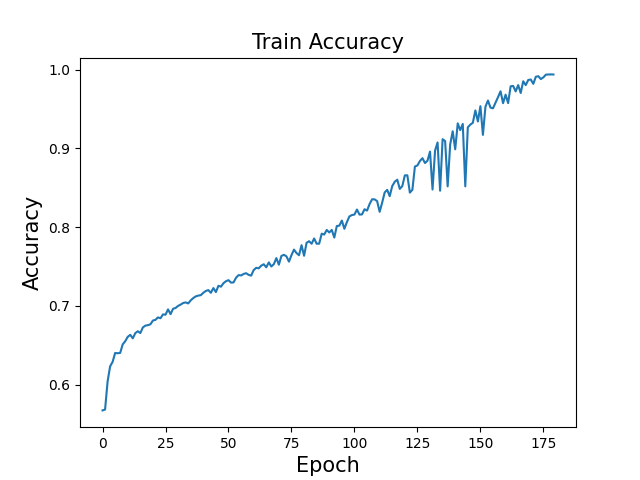

In [8]:
# %%space weeds_network
import train_weeds_network

# train_weeds_network.run_model("network_params.npy")
d = np.load("weeds_network_accuracy.npz")
# plt.plot(d["train"])
fig, ax = plt.subplots()
ax.plot(d["train"])
ax.set_xlabel("Epoch", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
ax.set_title("Train Accuracy", fontsize=15)
None

**Wow!** This is great! We have achieved $99\%$ accuracy on our training dataset! Before we celebrate, lets check to see what will happen if users input their own data. To achieve this, we hid a set of images from our network and can compare how our network performs on these new images!

## Testing the network on new images

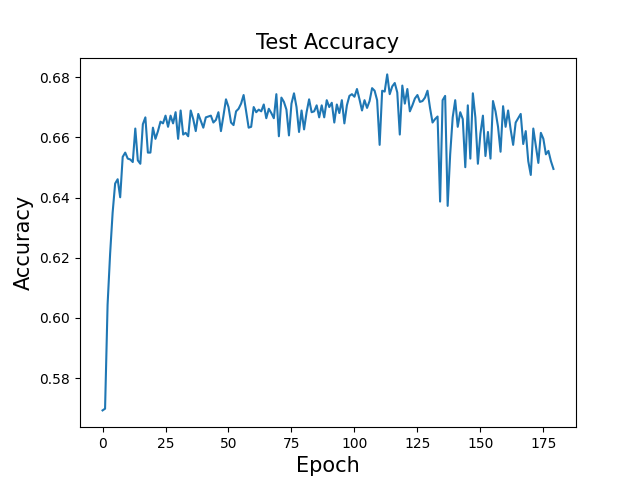

In [9]:
# %%space weeds_network
# import train_weeds_network

# train_weeds_network.run_model("network_params.npy")
# d = np.load("weeds_network_accuracy.npz")
# plt.plot(d["train"])
fig, ax = plt.subplots()
ax.plot(d["test"])
ax.set_xlabel("Epoch", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
ax.set_title("Test Accuracy", fontsize=15)
None

**Oh No!!** While our neural network performs well in our training data, the network on new data struggles to perform better than $68\%$ *and* with more training the test accuracy seems to be getting worse. While we don't diagnose this phenomenon in this notebook, it is called overfitting. Our network has done a good job at memorizing the training data, but has not learned a function which generalizes to new examples. This is a common occurance when applying neural networks, and often requires empirical testing and expertise to remedy.

Now that you've gone through the example, answer the following questions to the best of your ability. Don't worry if you don't get every answer correct, but try to apply what you have learned. 
1. Will it work well on all the plant pictures a user might feed it? What could you imagine being an issue?
2. How would we communicate to the user when the system recieves an image it doens't know how to classify?
3. Should we deploy our hypothetical App? What kinds of applications should we be more careful about?
4. Come up with your own example app using a neural network for regression! (We only expect a few sentences focusing on the input an output of the network, you don't need to create a full example like we did here).

# Getting into the weeds (Extra)

TODO:
- Getting into the "weeds" *This could be extra if they are interested* -> Drop and drag interfaces? Maybe using drop down menus… This could even very simply actually implement the weed classification toy example and they can see how their changes effects the outcomes (see https://playground.tensorflow.org/ for an example of this idea).
    - Different losses produce different answers -> Extending the outputs section
    - Input data cleaning needs to be thought through -> Different normalization techniques results in different levels of performance, your data may also need more cleaning.
    - Different architectures? -> Different configurations of layers result in the ability to learn from different types of data more easily.
    - Optimization is important (maybe not this far into the weeds) -> The algorithm we use for training can make a diffference in the networks ability to soak up data.
    - The transformation of data perspective of a neural network.